# Proyecto Time Series:

In [2]:
# Librería para la declaración y uso de Data Frames:
import pandas as pd

# Librería para poder hacer gráficos:
import matplotlib.pyplot as plt

# Líbrería para poder aplicar el Test de Dickey - Fuller: 
from statsmodels.tsa.stattools import adfuller

# Librería para poder utilizar la función que permita estudiar las componentes principales de la Time Series:
from statsmodels.tsa.seasonal import seasonal_decompose

# Librería para poder realizar operaciones matemáticas:
import numpy as np


## Paso 1 - Lectura de Datos:

En primer lugar, es necesario **leer y guardar la información** en una variable para poder empezar a trabajar con ella.

Para ello, se ha guaradado el archivo con todos los datos en la ruta: */workspaces/time-series--clara-ab/data/raw/sales.csv* y se ha cargado en un Data Frame:

In [3]:
# Lectura del CSV con los datos, dada la ruta donde se guarda el archivo:
df = pd.read_csv ('/workspaces/time-series--clara-ab/data/raw/sales.csv');

# Configuración de pandas para mostrar todas las columnas del DataFrame sin truncarlas al visualizarlo
pd.set_option('display.max_columns', None);

# Se muestran las 5 primeras filas del Data Frame
df.head()

date      sales
0  2022-09-03 17:10:08.079328  55.292157
1  2022-09-04 17:10:08.079328  53.803211
2  2022-09-05 17:10:08.079328  58.141693
3  2022-09-06 17:10:08.079328  64.530899
4  2022-09-07 17:10:08.079328  66.013633

Una vez se ha cargado correctamente la información en el Data Frame es interesante evaluar la **cantidad de información** que se tiene. Para ello, se recurre al atributo `.shape` del Data Frame:

In [4]:
# Se utiliza el atributo shape del Data Frame para conocer cuánta información está cargada:
print (f" El conjunto de datos cuenta con información de {df.shape[0]} ventas con total de {df.shape[1]} tipos de información sobre ellas");

 El conjunto de datos cuenta con información de 366 ventas con total de 2 tipos de información sobre ellas


Si se estudia el conjunto de datos, se puede observar que hay **dos variables**: 

- `date` : Día y hora exacta de registro de la venta

- `sales` : Total vendido

Para poder trabajar con esta información, es necesario saber bien qué **tipo de datos** son:

In [5]:
# Se imprime el tipo de dato de cada característica:
df.dtypes

date      object
sales    float64
dtype: object

Como se ha podido observar, la **fecha y hora exacta** del registro de venta no es del tipo `DateTime`, si no que es un **objeto**. Por ello, en primer lugar, se va a realizar este **cambio de variable**:

In [6]:
# Se realiza un cambio de variable de la columna `date`:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

Además, como se ha podido ver, hay **un registro por día a lo largo de un año** (Tensor: 1 día), desde el 3 de Septiembre del 2022 hasta el 3 de septiembre del 2023 pero **siempre se realiza dicho registro a la misma hora**.

Esto implica que dentro de la variable `date` **solo interesa la fecha**, **no la hora**, por lo que se puede eliminar para tratar con los datos de forma más ágil. 

In [7]:
# Solo se guarda la fecha:
df['date'] = df['date'].dt.date
df.head()

date      sales
0  2022-09-03  55.292157
1  2022-09-04  53.803211
2  2022-09-05  58.141693
3  2022-09-06  64.530899
4  2022-09-07  66.013633

## Paso 2 - Análisis Exploratorio de Datos:

Antes de realizar cualquier tipo de predicción, es fundamental llevar a cabo un **análisis de los datos** para poder identificar **patrones**, detectar **valores atípicos** y evaluar la **distribución** de las variables para comprender la **relación** entre ellas.

Por este motivo, se van a realizar distintos pasos cuyo objetivo final es **preparar el conjunto de datos para poder trabajar con ellos**. Este EDA va a ser breve, no se va a explicar en detalle como se ha venido haciendo en los proyectos anteriores. Simplemente se irá paso a paso realizando un estudio y solo se hará un breve comentario al final con las decisiones que se hayan tomado.

### Paso 2.1 - Análisis de Constantes y Duplicados:

In [8]:
# Se utiliza el método .nunique() para saber la cantidad de columnas con constantes en el Data Frame:
print(f" Hay un total de {(lambda df: (df.nunique() == 1).sum())(df)} columnas en el Data Frame con un valor constante para todas las ventas");

# Se imprime el conteo de valores distintos en cada columna:
print (f" \nPara cada columna del Data Frame, se muestran cuántos valores distintos presentan:");
df.nunique()

 Hay un total de 0 columnas en el Data Frame con un valor constante para todas las ventas
 
Para cada columna del Data Frame, se muestran cuántos valores distintos presentan:


date     366
sales    366
dtype: int64

A partir del resultado obtenido se puede observar que **no hay ninguna constante** en los datos cargados, por lo tanto no hay que eliminar ninguna columna, como era de esperar al tener solo la fecha+hora y el número total de la venta. 

In [9]:
# Se utiliza el método .duplicated() para identificar las ventas repetidas dentro del DataFrame:
print(f" Hay un total de {df.duplicated().sum()} ventas duplicadass.");

 Hay un total de 0 ventas duplicadass.


### Paso 2.2 - Análisis Estadístico:

In [10]:
# Descripción estadística básica de todas las columnas del DataFrame:
df.describe(include='all').T # Se traspone para ver de forma más clara los datos

count unique         top freq        mean         std        min  \
date     366    366  2023-09-03    1         NaN         NaN        NaN   
sales  366.0    NaN         NaN  NaN  524.963968  275.089698  53.803211   

              25%         50%         75%          max  
date          NaN         NaN         NaN          NaN  
sales  290.186822  520.699468  763.289263  1000.482785

En este caso, lo que se quería comprobar es que no se contaban con **datos de ventas negativos o iguales a 0**, dado que serían errores. **No se ha encontrado nada de este tipo**, por lo que no se hace ningún filtrado en base a este análisis. 

### Paso 2.3 - Análisis de Nulos:

In [11]:
# Se comprueba el porcentaje de ventas que presentan al menos un valor nulo:
print(f" El {round(df.isnull().any(axis=1).mean()*100, 2)} % de las ventas presenta, al menos, un valor nulo en alguna de sus características descriptivas");

 El 0.0 % de las ventas presenta, al menos, un valor nulo en alguna de sus características descriptivas


**No hay ningún nulo** dentro del conjunto de datos.

## Paso 3 - Construcción y Análisis de la Serie Temporal:

Una vez se tiene el conjunto de datos preparado para el análisis, es interesante realizar un estudio para ver cuál es el **comportamiento del escenario**. 

Para ello, en primer lugar, se va a trazar una **gráfica simple** de forma que se pueda ver la **tendencia de ventas a lo largo de un año**:

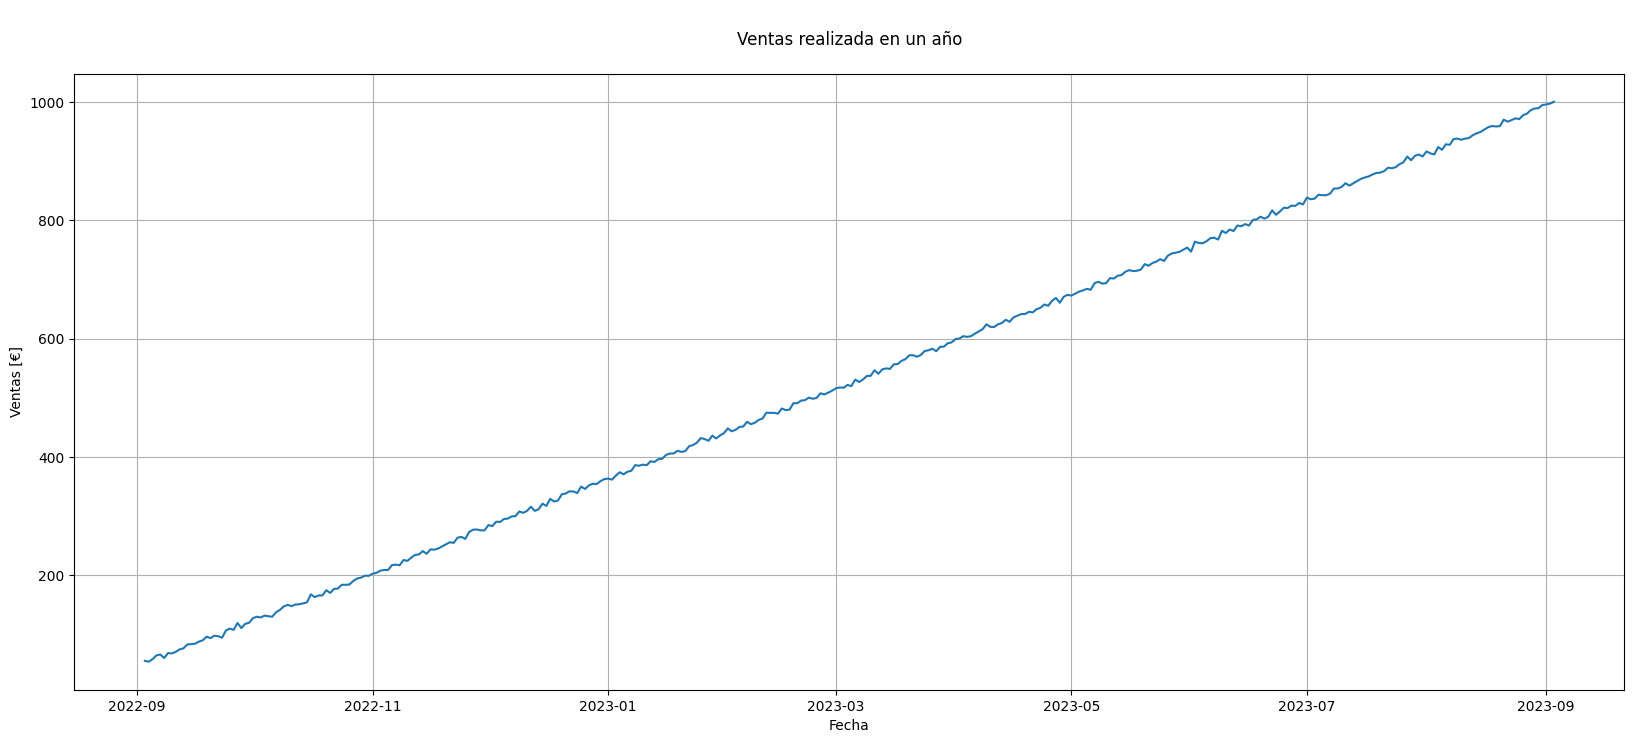

In [12]:
# Se genera la figura: 
plt.figure (figsize = (20,8));

# Se grafica la línea de tendencia:
plt.plot(df.date, df.sales);
plt.xlabel ('Fecha');
plt.ylabel('Ventas [€]');
plt.title ('\nVentas realizada en un año\n');
plt.grid(True);

# Se muestra: 
plt.show()

El negocio **no ha parado de crecer** desde su apertura. La tendencia de las ventas ha sido **inequívocamente ascencente**, solo habiendo ligeras fluctuaciones en momentos puntuales. 

Para poder analizar *más de cerca* esas pequeñas variaciones, se va a obtener **una gráfica por mes**. Con este objetivo, se van a generar **dos nuevas variables**, `month` y `day` de forma que se puedan **filtrar** e ir recorriendo para ver la **tendencia mensual**:

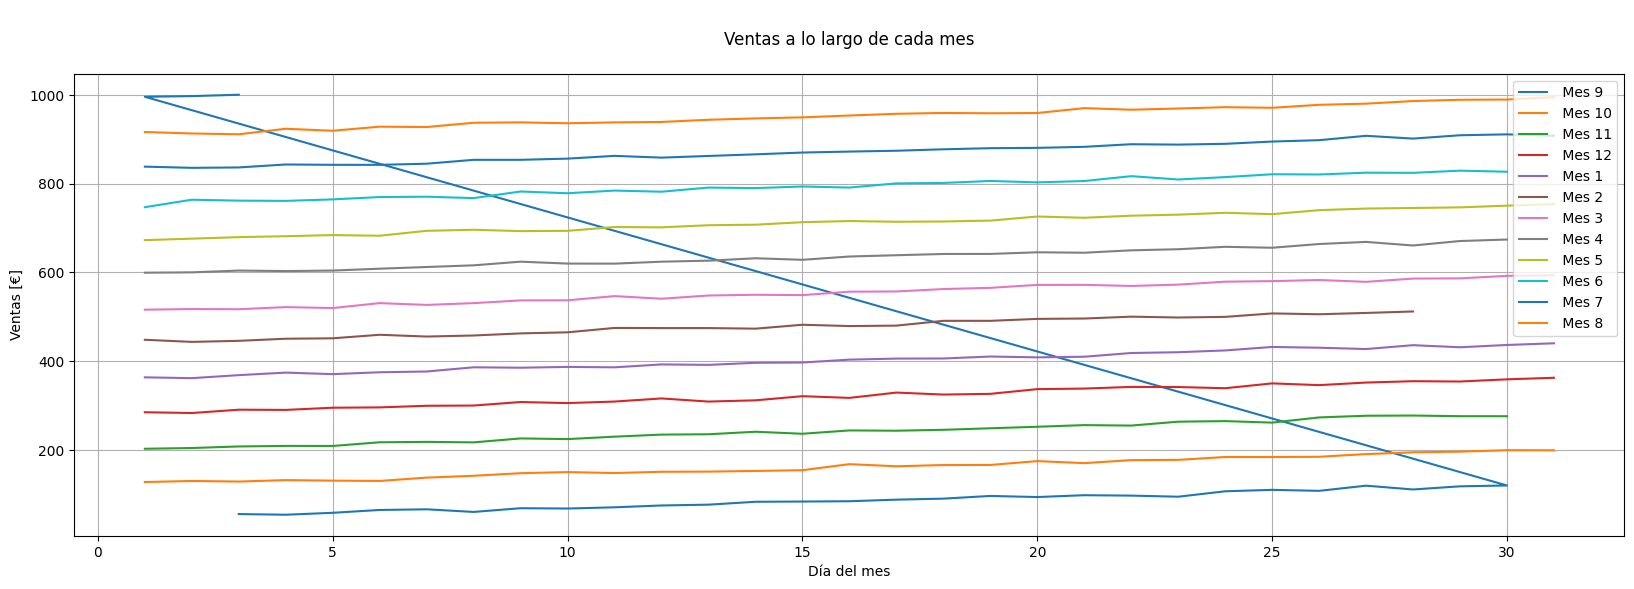

In [13]:
# Se vuelve a convertir la variable `date` de DateTime:
df['date'] = pd.to_datetime(df['date']);

# Se obtiene el mes:
df['month'] = df['date'].dt.month;

# Se obtiene el día:
df['day'] = df['date'].dt.day;

# Se genera la figura:
plt.figure(figsize=(20, 6))

# Se recorren todos los meses del conjunto de datos:
for month in df['month'].unique(): 

    # Se filtra el mes sobre el que se está iterando:
    df_month = df[df['month'] == month];

    # Se grafica la venta del día concreto del mes:
    plt.plot(df_month['day'], df_month['sales'], label = f" Mes {month}");


# Se añade información:
plt.xlabel("Día del mes");
plt.ylabel("Ventas [€]");
plt.title("\nVentas a lo largo de cada mes\n")
plt.legend();
plt.grid(True);

# Se muestra la gráfica:
plt.show();

Lo primero que es importante aclarar es que el conjunto de datos **empieza y acaba en Septiembre**, es decir, Mes 9. Es por esta razón por la cual la **línea correspondiente está tanto en los valores más bajos** (peores ventas) **como en los más altos** (mejores ventas). El **primer caso** hace referencia a los datos relativos a la **apertura** del negocio y el **último** a los resultados **al cabo de un año**. 

A parte de esto, **no hay nada destacable en cuanto a tendencias dentro de un mismo mes**. Se ve que hay ligeras fluctuaciones pero ninguna es habitual en todos los meses. 

Por otro lado, para estudiar la **estacionalidad**, lo primero es necesario saber que, si una serie es **estacionaria**, sus **propiedades estadísticas no cambian con el tiempo**. Esto es muy importante para el **modelo ARIMA** que se utilizará más adelante, dado que requiere que los datos sean estacionarios. Para poder averiguarlo, se puede aplicar el test de **Dickey-Fuller** en el que se tienen las siguientes hipótesis: 

- **Hipótesis Nula:** La serie NO es estacionaria

- **Hipótesis Alternativa:** La serie es estacionaria

De esta forma, si el p-valor es menor a 0.05, NO se rechaza la hipótesis alternativa y, por lo tanto, la serie temporal es estacionaria.

Para poder evaluarlo, se va a utilizar la función `adfuller`de `statsmodels` :

In [14]:
# Se aplica el test: 
test_df = adfuller(df['sales']);

# Se imprime el P - Valor:
print(f"p-value: {round(test_df[1], 4)}") ; # Si el p-valor es < 0.05, la serie es estacionaria

p-value: 0.9862


El **P-Valor es mayor que 0.05** por lo que se **rechaza la Hipótesis Alternativa**, tomando que la serie **NO es estacionaria.** Esto luego hará que, para **aplicar el modelo ARIMA**, se deba realizar un **cambio**

Finalmente, para estudiar la presencia de ruido**se va a utilizar la función `seasonal_decompose` de la librería  `statsmodel`, de forma que se pueda **descomponer la serie temporal** bajo estudio en sus **componentes principales** (volverá a aparecer la tendencia y la estacionalidad, pero va a ser útil para reafirmar el análisis previo). 

Sin embargo, para poder utilizarlo, es necesario entender dos de los parámetros que se han de pasar:

- `model`: Forma en la que realizar la descomposición de la serie temporal. Puede ser **aditivo**, donde la serie temporal se despone en la **suma** de sus componentes (adecuado cuando la tendencia es constante a lo largo del tiempo) o **multiplicativo**, donde la serie temporal se descompone como **producto** de sus componentes (adecuado cuando las variaciones estacionales se amplifican cuando la serie aumenta). En este caso, las **fluctuaciones no se vuelven más pronunciadas con el tiempo**, dado que el crecimiento de la gráfica es más o menos constante independientemente del momento de la serie temporal, por lo que se va a escoger el **modelo aditivo**. 

- `period`: Número de observaciones necesarias para que se repita un **patrón estacional completo**. El valor de este parámetro depende de los datos y su frecuencia, pudiendo ser **mensuales** (donde un ciclo completo de la estacionalidad se repite cada 12 meses), **diarios** (donde el patrón se repite cada mes) o **anuales** (si no hay un patrón estacional claro). En este caso, como se va a querer **evaluar qué pasará en los próximos MESES**, se va a optar por un periodo **mensual**.

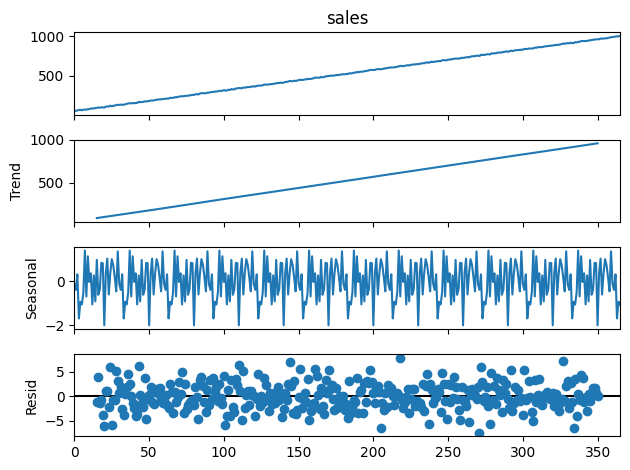

In [15]:
# Se extraen los componentes de la serie temporal:
componentes_time_series = seasonal_decompose(df.sales, model='additive', period = int(len(df)/12));
componentes_time_series.plot();
plt.show()

Como ya se había visto previamente, la tendencia es claramente ascendente. 

Por otro lado, la **Estacionalidad** muestra los patrones que se repiten en el **intervalo de un mes**. El resultado que se ha obtenido también tiene lógica con lo evaluado anteriormente dado que se ve una **tendencia creciente a lo largo de la media de 30 días**. Esto significa que **a principios de cada mes siempre se registra un total de ventas menor que al final** (relacionado con la constante tendencia creciente). 

Por último, el **Residuo**, es lo que queda después de haber **extraído las otras dos componentes de la serie temporal**. Este parámetro representa las **fluctuaciones aleatorias** que no pueden explicarse por las otras dos componentes. Esto implica que, si los **residuos son pequeños** o están distribuidos de forma **aleatoria**, se entiende que el **modelo ha captado bien los patrones**. Si, por lo contrario, **se encuentran patrones en el residuo**, no se ha logrado **capturar** completamente la **variabilidad** de los datos a través de las otras dos componentes. En este caso, el **residuo parece bastente disperso**, con lo que parece que la serie temporal se ha explicado con las otras dos variables.




## Paso 4 - Entrenamiento de ARIMA:

Lo primero que se va a realizar, sabiendo que se va a aplicar el modelo ARIMA, es **aplicar una diferenciación sobre los datos** dado que este algoritmo **requiere una serie estacionaria** y, con la que se está trabajando no lo son: 

In [16]:
df['sales'] = df['sales'].diff().dropna()

Ahora, para poder generar una predicción con un modelo ARIMA, es imprescindible realizar una **división en el conjunto de datos** para tener una parte de entrenamiento y otra de prueba, de forma que se pueda probar el modelo **sin inferir en su capacidad predictiva**. 

En este caso, se indica que el **objetivo** es poder predecir qué va a pasar en los **próximos meses** para saber cómo proveer el nuevo espacio que necesitará el negocio. Por este motivo, y teniendo en cuenta que se tiene información de un **total de 12 meses**, se van a usar una serie de **meses para entrenar** (9 meses) y otros para **probar** (3 meses). 

Con este objetivo, se va utilizar la columna `month` que se creó previamente y se **filtrará teniendo los 9 primeros meses en el conjunto de entrenamiento** y los **3 últimos en el de prueba**. Es improtante recalcar que el **mes de septiembre está dos veces**. Para comrprobar que el train set no ha quedado desbalanceado, una vez se haga la separación se va a **calcular el porcentaje que representa cada uno de los conjuntos sobre el total**. 


In [17]:
# Se filtran los 9 primeros meses para el train set:
train_set = df[df['month'] <= 9];

# Se filtran los 3 últimos meses para el test set:
test_set = df[df['month'] > 9];

print(f" El conjunto de train representa un {round((len(train_set)/len(df)*100), 2)} %");
print(f" El conjunto de test representa un {round((len(test_set)/len(df)*100), 2)} %");

 El conjunto de train representa un 74.86 %
 El conjunto de test representa un 25.14 %


Los **porcentajes** que se han obtenido para cada uno de los conjuntos se valora como **adecuado**. 

Ahora que ya se va a pasar a entrenar al modelo, se debe "limpiar" antes el conjunto de datos de las variables creadas para facilitar el análisis de la serie temporal (columna `day` y `month`) y **separar la serie temporal** del resto de variables:

In [19]:
train_set.set_index('date')
test_set.set_index('date')

sales  month  day
date                            
2022-10-01  7.762629     10    1
2022-10-02  2.412478     10    2
2022-10-03 -1.340494     10    3
2022-10-04  3.272385     10    4
2022-10-05 -1.195105     10    5
...              ...    ...  ...
2022-12-27  5.814119     12   27
2022-12-28  3.037126     12   28
2022-12-29 -0.704046     12   29
2022-12-30  4.910008     12   30
2022-12-31  3.527122     12   31

[92 rows x 3 columns]

In [20]:
# Se deja únicamente la variable date en el conjunto de datos:
x_train = train_set ['date'];
x_test = test_set ['date'];

# Se separa la serie temporal: 
y_train = train_set ['sales'];
y_test = test_set ['sales'];

In [103]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y_train, order=(1, 1, 1))  # p=1, d=1, q=1 como ejemplo
model_fit = model.fit()

# Resumen del modelo ajustado
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  274
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1136.543
Date:                Thu, 06 Feb 2025   AIC                           2279.087
Time:                        22:33:00   BIC                           2289.915
Sample:                             0   HQIC                          2283.434
                                - 274                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6172      2.180     -0.283      0.777      -4.890       3.655
ma.L1          0.5817      2.242      0.259      0.795      -3.812       4.976
sigma2       241.8769      4.383     55.184      0.0

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [25]:
from pmdarima import auto_arima

#model = auto_arima(y_train, seasonal = False, trace = True, m = int(366/12))
# Ejecutar auto_arima para encontrar los mejores parámetros
model = auto_arima(list(range(100)),  
                   seasonal=False,  # No estamos usando SARIMA (sin estacionalidad)
                   trace=True,      # Muestra el proceso de selección
                   suppress_warnings=True) 

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject